# Coding Challenge

### Introduction
To get an understanding about your technical communication skills, we would like you
to complete the following challenge and prepare to present your solution to us in the
next step of the interview process. This exercise is designed to help us get to know your
working style better considering logical and analytical thinking, structure and
communication skills.
The exercise should be relatively fast to complete. How much time you spend on the
challenge is totally up to you. If this contains many new things, a few evenings should
be enough time.

### Exercise
##### Requirements and submission guidelines
- Use source data set from https://archive.ics.uci.edu/ml/datasets/Online+Retail
- Create a jupyter notebook with a python ETL script that will process raw data into target file(s) for data warehouse
- Create a dashboard based on a data warehouse’ file(s) in Google Data Studio that will present results of analysis
- Provide a link to the Git private repository with the code and documentation.
- Take some time to think about code quality, testing and analysis; and demonstrate your approach to these aspects
- Provide a README with instructions on how to set up and run the project
- If you run out of time, please return a partial solution, and describe in your reply how you would continue having more time

# Solution

### Import Libraries

In [190]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import pandas_gbq
from google.oauth2 import service_account


#Service account credentials
credentials = service_account.Credentials.from_service_account_file(
    'coding-challenge-9898-67497b5a9156.json',
)

### Import data

In [291]:
strfilename = 'Online Retail.xlsx'
df = pd.read_excel(strfilename,engine='openpyxl')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


##### Checking datatypes

In [292]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

##### Checking null values

In [293]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [294]:
# Number of rows and columns to be inserted
df.shape

(541909, 8)

##### Approx 25% of CustomerID is missing

<AxesSubplot:>

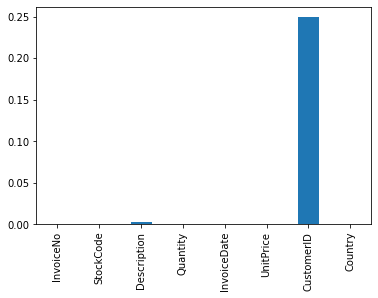

In [295]:
missingvalues = df.isnull().sum()
df_missingvalues = pd.DataFrame({'Count':missingvalues})
df_missingvalues['Total'] = df.shape[0]
df_missingvalues['Percent_of_Null_values'] = df_missingvalues['Count']  /  df_missingvalues['Total'] 
df_missingvalues['Percent_of_Null_values'].plot(kind='bar')

### Preprocessing

In [296]:
newdf = df.copy()

##### Adding sales columns

In [297]:
newdf['Sales']=newdf['Quantity']*newdf['UnitPrice']

##### Convert stockcode to upper case as there are similar code with a upper and lower letters at the end

In [298]:
def clean_stockcode(text):
    try:
        cleantext = text
        if text.isnumeric():
            cleantext = text
        else:
            cleantext = text.upper()
    except:
        cleantext = text
        pass
    return cleantext

newdf['StockCode'] = newdf.StockCode.apply(clean_stockcode)

newdf.head()



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


##### Extracting product category from description taking last two words

In [299]:
newdf['ProductCategory'] = newdf['Description'].str.split().str[-2:].str.join(' ')
newdf['ProductCategory'] = newdf['ProductCategory'].str.replace('[^\w\s]','')
newdf['ProductCategory'] = newdf['ProductCategory'].str.upper()
newdf['ProductCategory'] = newdf['ProductCategory'].str.strip()
newdf['ProductCategory'].value_counts()

METAL SIGN           10908
TLIGHT HOLDER         9157
CAKE CASES            8074
WATER BOTTLE          7063
RED RETROSPOT         6816
                     ...  
DAMAGESDOTCOM            1
PALLETTHROWN AWAY        1
CRACKED                  1
LACE CCOVER              1
SINGING CANARY           1
Name: ProductCategory, Length: 2533, dtype: int64

##### Order status

In [300]:
newdf['OrderStatus'] = 'Completed'

newdf.loc[newdf[newdf.InvoiceNo.str.contains('C', na=False)].index,"OrderStatus"] = "Cancelled"

In [301]:
newdf.shape

(541909, 11)

### Connect to Google Cloud API and Upload Dataframe

In [302]:
newdf.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,ProductCategory,OrderStatus
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,TLIGHT HOLDER,Completed
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,METAL LANTERN,Completed
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,COAT HANGER,Completed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,WATER BOTTLE,Completed
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,WHITE HEART,Completed


In [303]:
pandas_gbq.to_gbq(
    newdf, 'sales_dataset.online_retail', project_id='coding-challenge-9898', if_exists='replace',
)

1it [01:13, 73.99s/it]


# Customer Segmentation

### Calculating customer's frequency in buying

In [225]:
frequency_df = newdf.copy()
frequency_df.drop_duplicates(subset=['CustomerID','InvoiceNo'], keep="first", inplace=True) 
frequency_df = frequency_df.groupby('CustomerID',as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


### Calculating customer's total amount

In [228]:
monetary_df=newdf.groupby('CustomerID',as_index=False)['Sales'].sum()
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


### Combining both the metrics for segmenting

In [229]:
mf = monetary_df.merge(frequency_df,left_on='CustomerID',right_on='CustomerID')
mf.set_index('CustomerID',inplace=True)
mf.head()

,Monetary,Frequency
CustomerID,,
12346.0,0.00,2
12347.0,4310.00,7
12348.0,1797.24,4
12349.0,1757.55,1
12350.0,334.40,1


### Using Kmeans clustering and dividing the customers into 4 clusters

In [238]:
customer_segmentation = mf.copy()
kmeans = KMeans(n_clusters=4, random_state=0).fit(customer_segmentation)
customer_segmentation['cluster'] = kmeans.labels_


In [239]:
customer_segmentation.reset_index(inplace=True)
customer_segmentation.head()

,CustomerID,Monetary,Frequency,cluster
0,12346.0,0.00,2,0
1,12347.0,4310.00,7,0
2,12348.0,1797.24,4,0
3,12349.0,1757.55,1,0
4,12350.0,334.40,1,0


In [240]:
customer_segmentation.cluster.value_counts()

0    4252
3     102
2      15
1       3
Name: cluster, dtype: int64

### Visualizing the segments using matplotlib graphs

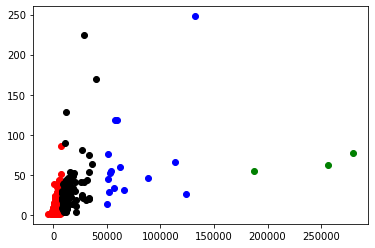

In [252]:
filtered_label0 = customer_segmentation[customer_segmentation.cluster == 0]
filtered_label1 = customer_segmentation[customer_segmentation.cluster == 1]
filtered_label2 = customer_segmentation[customer_segmentation.cluster == 2]
filtered_label3 = customer_segmentation[customer_segmentation.cluster == 3]
plt.scatter(filtered_label0.Monetary , filtered_label0.Frequency , color = 'red')
plt.scatter(filtered_label1.Monetary , filtered_label1.Frequency , color = 'green')
plt.scatter(filtered_label2.Monetary , filtered_label2.Frequency , color = 'blue')
plt.scatter(filtered_label3.Monetary , filtered_label3.Frequency , color = 'black')
plt.show()

### Segmenting the customer type based on frequency and amount of purchase

In [264]:
customer_segmentation.head()

customer_segmentation['TypeOfCustomer'] = 'Average buy'
customer_segmentation.loc[customer_segmentation[customer_segmentation.Monetary >=75000].index,'TypeOfCustomer'] = 'Spenders'
customer_segmentation.loc[customer_segmentation[(customer_segmentation.Monetary >=75000) & (customer_segmentation.Frequency >=75)].index,'TypeOfCustomer'] = 'Best'
customer_segmentation.loc[customer_segmentation[(customer_segmentation.Monetary <75000) & (customer_segmentation.Monetary >=25000) & (customer_segmentation.Frequency >=75)].index,'TypeOfCustomer'] = 'Loyal'
customer_segmentation.loc[customer_segmentation[(customer_segmentation.Monetary <75000) & (customer_segmentation.Monetary >=25000) & (customer_segmentation.Frequency <75)].index,'TypeOfCustomer'] = 'Medium buy'
customer_segmentation.loc[customer_segmentation[(customer_segmentation.Monetary <25000) & (customer_segmentation.Frequency >=75)].index,'TypeOfCustomer'] = 'Frequent buy'

customer_segmentation.TypeOfCustomer.value_counts()


Average buy     4335
Medium buy        20
Loyal              7
Spenders           5
Frequent buy       3
Best               2
Name: TypeOfCustomer, dtype: int64

In [265]:
customer_segmentation.head()

,CustomerID,Monetary,Frequency,cluster,TypeOfCustomer
0,12346.0,0.00,2,0,Average buy
1,12347.0,4310.00,7,0,Average buy
2,12348.0,1797.24,4,0,Average buy
3,12349.0,1757.55,1,0,Average buy
4,12350.0,334.40,1,0,Average buy


### Connect to Google Cloud API and Upload Dataframe

In [281]:
pandas_gbq.to_gbq(
    customer_segmentation, 'sales_dataset.customer_segmentation', project_id='coding-challenge-9898', if_exists='replace',
)

1it [00:05,  5.57s/it]
